# Object Detection

Here is my code : https://colab.research.google.com/drive/1BMbAYFFjvqP7tV1gvvp5RRHp-m-jVIOy?usp=sharing

## Library

In [ ]:
# Pip install method (recommended)

#yolo v8
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

!pip install -U gdown -qq
!pip install split-folders -qq

Ultralytics YOLOv8.0.35 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.4/166.8 GB disk)


Cloning into 'ultralytics'...
remote: Enumerating objects: 4546, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 4546 (delta 81), reused 101 (delta 33), pack-reused 4365
Receiving objects: 100% (4546/4546), 4.07 MiB | 24.92 MiB/s, done.
Resolving deltas: 100% (2955/2955), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 KB 7.2 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import pandas as pd
import json
import copy
from tqdm import tqdm
import numpy as np

# import splitfolders

from ultralytics import YOLO
import ultralytics

import cv2
from google.colab.patches import cv2_imshow
from skimage import io

import warnings
warnings.filterwarnings("ignore")

import imageio.core.util

## Load data

In [ ]:
!gdown 1HIB5GLU6kBMqGeH5z10x3N5KLQPrewzW #train
!gdown 1QE2XOMhya1u_lu82ujWjCHC2GoG7oqeY #test
!gdown 1NWObOOt9Hj75xf0xGeugaH-OEE-IAaYQ #train_annotations.json
!gdown 1x6LQ-Kjm6G_lfun09MrhfRTh1D2eek-H #ไฟล์ yaml(ยำแมว)

Downloading...
From: https://drive.google.com/uc?id=1HIB5GLU6kBMqGeH5z10x3N5KLQPrewzW
To: /content/train.zip
100% 776M/776M [00:02<00:00, 275MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QE2XOMhya1u_lu82ujWjCHC2GoG7oqeY
To: /content/test.zip
100% 150M/150M [00:00<00:00, 188MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NWObOOt9Hj75xf0xGeugaH-OEE-IAaYQ
To: /content/train_annotations.json
100% 673k/673k [00:00<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x6LQ-Kjm6G_lfun09MrhfRTh1D2eek-H
To: /content/coco129.yaml
100% 801/801 [00:00<00:00, 1.54MB/s]


In [ ]:
!unzip -q /content/train.zip
!unzip -q /content/test.zip

## Normalize Data

In [ ]:
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    normalized_img = (image - mean) / std
    return normalized_img

In [ ]:
#ทำให้เวลา save รูปของ skiimage ให้มันไม่ต้องโชว์ผลลัพธ์
def ignore_warnings(*args, **kwargs):
    pass

imageio.core.util._precision_warn = ignore_warnings

In [ ]:
base = '/content/train'
for i in tqdm(os.listdir(base)):
  img_path = os.path.join(base, i)
  image = io.imread(img_path)
  normalized_image = normalize(image)
  io.imsave(f"{img_path}", normalized_image)

100%|██████████| 13363/13363 [05:42<00:00, 38.99it/s]


In [ ]:
base = '/content/test'
for i in tqdm(os.listdir(base)):
  img_path = os.path.join(base, i)
  image = io.imread(img_path)
  normalized_image = normalize(image)
  io.imsave(f"{img_path}", normalized_image)

100%|██████████| 2500/2500 [00:59<00:00, 41.99it/s]


## Read

In [ ]:
f = open('/content/train_annotations.json')
data = json.load(f)

In [ ]:
row = []
for i in tqdm(data):
  try:
    path = os.path.join('/content/train', i)
    img = cv2.imread(path)
    H, W = img.shape[:-1]
    dic = data[i]
    boxes = dic['boxes']
    labels = dic['labels']
    com = 10
    if len(boxes) != 0:
      for j in range(len(boxes)):
        # print(boxes[j])
        x1 = boxes[j][0]
        y1 = boxes[j][1]
        x2 = boxes[j][2]
        y2 = boxes[j][3]

        cls = labels[j]

        row.append([x1, y1, x2, y2, cls, path, H, W])
    else:
      row.append([0, 0, 0, 0, 3, path, H, W])

  except:
    print('\n', path)
    pass

 78%|███████▊  | 10484/13364 [00:41<00:16, 178.12it/s]


 /content/train/.DS_Store


100%|██████████| 13364/13364 [00:52<00:00, 255.13it/s]


In [ ]:
df = pd.DataFrame(row, columns=['x1', 'y1', 'x2', 'y2',  'class', 'path', 'H', 'W'])
df.head()

,x1,y1,x2,y2,class,path,H,W
0,439,315,506,384,0,/content/train/0.jpg,692,922
1,549,187,618,281,0,/content/train/1.jpg,660,880
2,293,254,315,273,0,/content/train/3.jpg,660,880
3,216,275,312,346,1,/content/train/4.jpg,660,880
4,509,150,579,234,1,/content/train/4.jpg,660,880


In [ ]:
df['x_center'] = (df['x2'] + df['x1']) / 2 / df['W']
df['y_center'] = (df['y2'] + df['y1']) / 2 / df['H']
df['x_ration'] = (df['x2'] - df['x1']) / df['W']
df['y_ration'] = (df['y2'] - df['y1']) / df['H']
df

,x1,y1,x2,y2,class,...,W,x_center,y_center,x_ration,y_ration
0,439,315,506,384,0,...,922,0.512473,0.505058,0.072668,0.099711
1,549,187,618,281,0,...,880,0.663068,0.354545,0.078409,0.142424
2,293,254,315,273,0,...,880,0.345455,0.399242,0.025000,0.028788
3,216,275,312,346,1,...,880,0.300000,0.470455,0.109091,0.107576
4,509,150,579,234,1,...,880,0.618182,0.290909,0.079545,0.127273
...,...,...,...,...,...,...,...,...,...,...,...
14148,0,0,0,0,3,...,880,0.000000,0.000000,0.000000,0.000000
14149,0,0,0,0,3,...,880,0.000000,0.000000,0.000000,0.000000
14150,0,0,0,0,3,...,880,0.000000,0.000000,0.000000,0.000000
14151,0,0,0,0,3,...,880,0.000000,0.000000,0.000000,0.000000


## Create folder format for Train Model

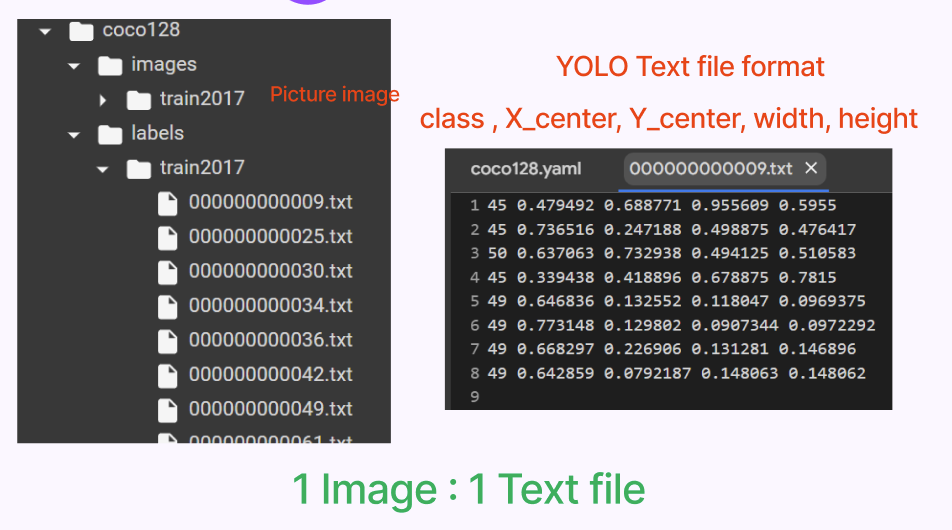

In [ ]:
!rm -rf /content/coco128

In [ ]:
!mkdir -p coco128/images/train
!mkdir -p coco128/labels/train

In [ ]:
#create folder for train
for i in tqdm(range(len(df))):
  try:
    image_path = df.loc[i, 'path'].split('/')[-1]
    image_path2 = f'/content/coco128/images/train/{image_path[:-4]}.jpg'
    
    if image_path not in os.listdir('/content/coco128/images/train'):
      shutil.copyfile(df.loc[i, 'path'], image_path2)
      label_path = '/content/coco128/labels/train'

      if df.loc[i, 'class'] != 3:
        f = open(f"{label_path}/{image_path[:-4]}.txt", "a")
        txt = f"{df.loc[i, 'class']} {df.loc[i, 'x_center']} {df.loc[i, 'y_center']} {df.loc[i, 'x_ration']} {df.loc[i, 'y_ration']}"
        idx = i
        while True:
          idx += 1
          if df.loc[idx, 'path'].split('/')[-1] == image_path:
            txt += f"\n{df.loc[idx, 'class']} {df.loc[idx, 'x_center']} {df.loc[idx, 'y_center']} {df.loc[idx, 'x_ration']} {df.loc[idx, 'y_ration']}"
          else:
            f.write(f"{txt}")
            break
      else:
        with open(f"{label_path}/{image_path[:-4]}.txt", 'w') as file:
          pass
  except:
    pass

100%|██████████| 14153/14153 [00:47<00:00, 298.62it/s]


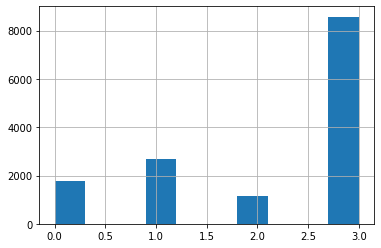

In [ ]:
df['class'].hist()

## Model

### Train

yaml format

```
# Ultralytics YOLO 🚀, GPL-3.0 license
# COCO128 dataset https://www.kaggle.com/ultralytics/coco128 (first 128 images from COCO train2017) by Ultralytics
# Example usage: python train.py --data coco128.yaml
# parent
# ├── yolov5
# └── datasets
#     └── coco128  ← downloads here (7 MB)


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: /content/coco128  # dataset root dir
train: images/train2017  # train images (relative to 'path') 128 images
val: images/train2017  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
names:
  0: cystic
  1: FFS
  2: solid


# Download script/URL (optional)
download: https://ultralytics.com/assets/coco128.zip
```

In [ ]:
!nvidia-smi

Sun Feb 12 04:54:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |   1838MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8x.pt')  # load a pretrained model (recommended for training) [yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt]

# Use the model
results = model.train(data='coco129.yaml', epochs=12, optimizer='SGD', batch=-1, project='model')  # train the model  optimizer to use, choices=['SGD', 'Adam', 'AdamW', 'RMSProp']

  0%|          | 0.00/131M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.35 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.yaml, data=coco129.yaml, epochs=12, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=model, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=Fals

      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    68155497       258.1         1.783         45.35         41.06        (1, 3, 640, 640)                    list
    68155497       516.3         2.238         53.36         52.09        (2, 3, 640, 640)                    list
    68155497        1033         3.750         97.88         107.5        (4, 3, 640, 640)                    list
    68155497        2065         6.786         215.4         218.7        (8, 3, 640, 640)                    list


AutoBatch: Using batch-size 10 for CUDA:0 10.51G/14.76G (71%) ✅
optimizer: SGD(lr=0.01) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00094482421875), 103 bias


    68155497        4130        12.721         388.3         461.8       (16, 3, 640, 640)                    list


train: Scanning /content/coco128/labels/train... 13363 images, 8576 backgrounds, 0 corrupt: 100%|██████████| 13363/13363 [00:04<00:00, 3117.94it/s]
train: New cache created: /content/coco128/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/coco128/labels/train.cache... 13363 images, 8576 backgrounds, 0 corrupt: 100%|██████████| 13363/13363 [00:00<?, ?it/s]
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to model/train
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/12      8.46G      1.729      3.568       1.43          3        640: 100%|██████████| 1337/1337 [19:19<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 669/669 [05:33<00:00,  2.00it/s]
            

### Predict

In [ ]:
#predict
%%time
model2 = YOLO('/content/model/train/weights/best.pt')
base = '/content/test'
lis = os.listdir(base)
for i in tqdm(lis):
  img_path = os.path.join(base, i)
  model2(source=f"{img_path}", save_txt=True, save_crop=True, project='predict', exist_ok=True, save=True, save_conf=True, conf=0.6)

 99%|█████████▉| 2478/2500 [02:28<00:01, 16.11it/s]
image 1/1 /content/test/8b08b70d-bd75-4edd-be00-67045c590013.jpg: 512x640 29.9ms
Speed: 0.7ms pre-process, 29.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to predict/predict
165 labels saved to predict/predict/labels

image 1/1 /content/test/585c3878-bec6-400c-bd49-fcf5f0d19b53.jpg: 512x640 31.2ms
Speed: 0.5ms pre-process, 31.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to predict/predict
165 labels saved to predict/predict/labels
 99%|█████████▉| 2480/2500 [02:29<00:01, 15.09it/s]
image 1/1 /content/test/d38a3767-07f4-44b7-992d-e0fd431b5941.jpg: 480x640 34.2ms
Speed: 0.5ms pre-process, 34.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to predict/predict
165 labels saved to predict/predict/labels

image 1/1 /content/test/68154baf-6d1c-4da5-a26c-e902b38d0666.jpg: 480x640 28.9ms
Speed: 0.5ms pre-process, 28.9ms inference, 1.2m

CPU times: user 2min 13s, sys: 3.51 s, total: 2min 16s
Wall time: 2min 30s


## Submit

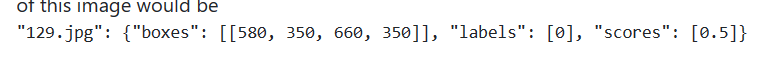

In [ ]:
def yolo_to_coco(x, y, w, h,  image_w, image_h):
  x1 = (x - w / 2) * image_w
  y1 = (y - h / 2) * image_h
  x2 = (x + w / 2) * image_w
  y2 = (y + h / 2) * image_h
  return [x1, y1, x2, y2]

In [ ]:
lis = os.listdir('/content/test')
all_name = []
all_dict = []
for i in lis:
  name = i
  img_path = '/content/test/' + i
  txt_file = i[:-4] + '.txt'
  all_name.append(name)
  if txt_file in os.listdir('/content/predict/predict/labels'):
    img = cv2.imread(img_path)
    image_h, image_w = img.shape[:-1]

    txt_file2 = os.path.join('/content/predict/predict/labels', txt_file)
    f = open(txt_file2)
    txt = (f.read())
    pred = txt.split('\n')[:-1]

    boxes = []
    labels = []
    scores = []

    # print(pred)
    for j in pred:
      value = j.split(' ')
      labels.append(int(value[0]))
      scores.append(float(value[5]))

      x_center = float(value[1])
      y_center = float(value[2])
      w = float(value[3])
      h = float(value[4])

      boxes.append(yolo_to_coco(x_center, y_center, w, h,  image_w, image_h))
      # print(labels)
      # print(boxes)
    all_dict.append({'boxes':boxes, 'labels':labels, 'scores':scores})
  else:
    all_dict.append({'boxes':[], 'labels':[], 'scores':[]})

In [ ]:
dic = dict(zip(all_name, all_dict))
print(len(all_dict), len(all_name))

2500 2500


In [ ]:
data = dict(zip(all_name, all_dict))

In [ ]:
with open('submit_ส่งงาน_liver_machima-2.txt', 'w') as convert_file:
     convert_file.write(json.dumps(data))

In [ ]:
# สำหรับส่งงานในระบบ https://liver.aiat.or.th/
# with open("submit_ส่งงาน.json", "w") as outfile:
#     json.dump(data, outfile)

In [ ]:
while True:pass #ทำให้มันไม่ตัด sesion